In [1]:
import gc
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import os
import keras_cv
import random

from os import path
from keras.utils import image_dataset_from_directory
from keras.applications.resnet import ResNet50, preprocess_input
from matplotlib import pyplot as plt
from keras import layers, losses, optimizers, metrics, callbacks

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=9048)]
    )

logical_gpus = tf.config.list_logical_devices('GPU')
print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")

1 Physical GPU, 1 Logical GPUs


In [3]:
SEED = 123
N_CLASS = 10
IMG_SIZE = 224

In [4]:
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [5]:
train_labels_df = pd.read_csv(path.join(os.getcwd(), 'train_val_test', 'train.csv')).drop(["Unnamed: 0"], axis=1)
dataset_train = image_dataset_from_directory(
    directory=path.join(os.getcwd(), 'train_val_test', 'train'),
    labels=list(train_labels_df['codes']),
    label_mode='int',
    validation_split=0,
    shuffle=True,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=512,
    seed=SEED
)
dataset_train = dataset_train.map(lambda x, y: (x, tf.one_hot(y, N_CLASS)))


Found 35000 files belonging to 1 classes.


## Data augmentation

241.99998


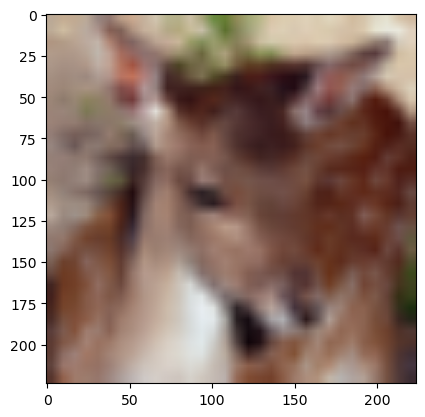

In [6]:
for img, label in dataset_train.take(1):
    print(img[0].numpy().max())
    plt.imshow(img[0].numpy().astype('int32'))

In [7]:
cut_mix = keras_cv.layers.preprocessing.cut_mix.CutMix(seed=SEED)

def apply_cut_mix(x, y):
    samples = {"images": x, "labels": y}
    samples = cut_mix(samples, training=True)
    return samples["images"], samples["labels"]

mix_up = keras_cv.layers.preprocessing.mix_up.MixUp(seed=SEED)

def apply_mix_up(x, y):
    samples = {"images": x, "labels": y}
    samples = mix_up(samples, training=True)
    return samples["images"], samples["labels"]
    

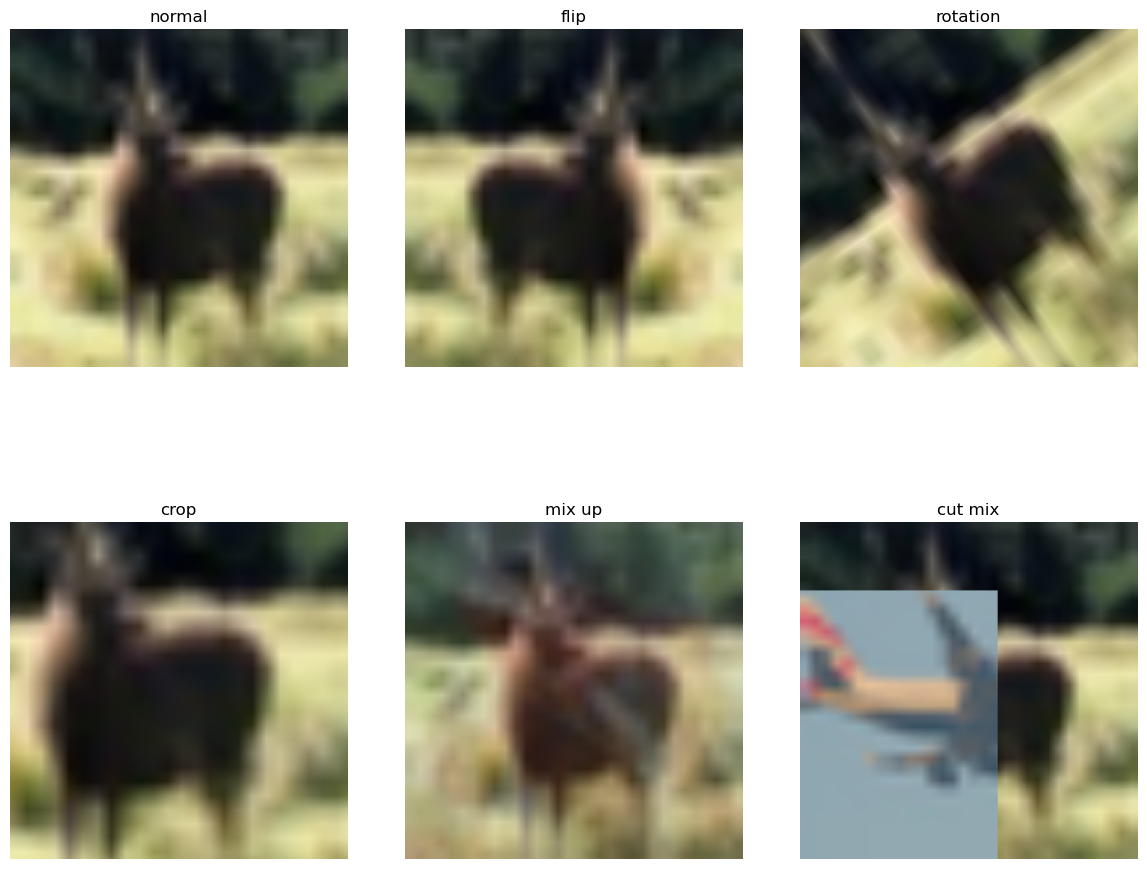

In [11]:
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

random_flip = layers.RandomFlip()
random_rotation = layers.RandomRotation(factor=(-0.3, 0.3))
random_crop = keras.Sequential([
    layers.RandomCrop(168, 168),
    layers.Resizing(IMG_SIZE, IMG_SIZE)]
)

augmentation_dict = {
    'flip' : random_flip,
    'rotation': random_rotation,
    'crop': random_crop,
    'mix up': apply_mix_up,
    'cut mix': apply_cut_mix
}

for imgs, labels in dataset_train.take(2):
    img = imgs[0]
    fig, ax = plt.subplots(2, 3, figsize=(12, 10))
    plt.tight_layout()
    ax[0][0].imshow(img.numpy().astype('int32'))
    ax[0][0].set_title("normal")
    ax[0][0].axis("off")
    for i, (name, transform) in enumerate(augmentation_dict.items()):
        row, column = (i + 1) // 3, (i + 1) % 3
        ax[row][column].axis("off")
        if not name in {'mix up', 'cut mix'}:
            augmented = transform(tf.expand_dims(img, 0), training=True)
            ax[row][column].imshow(augmented[0].numpy().astype('int32'))
            ax[row][column].set_title(name)
        else:
            augmented, labels = transform(imgs, labels)
            ax[row][column].imshow(augmented[0].numpy().astype('int32'))
            ax[row][column].set_title(name)
    break
    
plt.savefig("gallery/augmentation_picture", dpi=300)
plt.show()